In [16]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

# Study the data

In [2]:
#ratings.dat, UserID::MovieID::Rating::Timestamp
data = pd.read_csv(filepath_or_buffer='data/ratings.dat', sep='::', header=None, engine='python')
data.columns =['UserID', 'MovieID', 'Rating', 'Timestamp']
data.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
total_movies = data['MovieID'].nunique()
total_movies

3706

In [4]:
total_users = data['UserID'].nunique()
total_users

6040

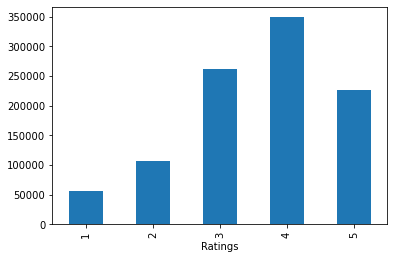

In [5]:
data['Rating'].value_counts(sort=False).plot(kind='bar')
plt.xlabel('Ratings')
plt.show()

In [6]:
def calculate_movie_popularity(user_movies): 
    movie_popularity = {}
    for _, movie_id in user_movies: 
        if movie_id not in movie_popularity: 
            movie_popularity[movie_id] = 1 
        else: 
            movie_popularity[movie_id] += 1
    return movie_popularity

checkdata = data[['UserID', 'MovieID']]
movie_popularity = calculate_movie_popularity(checkdata.values)

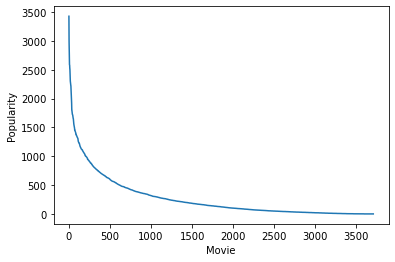

In [8]:
ranked_popularity = list(map(lambda x:x[1], movie_popularity.items()))
plt.plot(sorted(ranked_popularity, reverse=True))
plt.ylabel('Popularity')
plt.xlabel('Movie')
plt.show()

# Prepare data and build similarity matrix

In [20]:
x, y = data[['UserID', 'MovieID']].values, data['Rating'].values
x_train, x_test, _, _ = train_test_split(x, y, train_size = 0.8, random_state = 0)

In [21]:
def get_watched_movie_list(watched_movies): 
    user_movies = {} 
    for user_id, movie_id in watched_movies: 
        if user_id not in user_movies: 
            user_movies[user_id] = set([movie_id])
        else: 
            user_movies[user_id].add(movie_id)
    return user_movies

x_train_watched_movie_list = get_watched_movie_list(x_train)
x_test_watched_movie_list = get_watched_movie_list(x_test)

In [24]:
def calculate_user_similarity(user_movies):
    similarity_matrix = defaultdict(dict)
    all_users = user_movies.keys() 
      
    for user_a in tqdm(all_users): 
        for user_b in all_users: 
            if user_a < user_b: 
                similarity_matrix[user_a][user_b] = len(user_movies[user_a] & user_movies[user_b]) / np.sqrt(len(user_movies[user_a]) * len(user_movies[user_b])) 
                similarity_matrix[user_b][user_a] = similarity_matrix[user_a][user_b]
    
    return similarity_matrix

similarity_matrix = calculate_user_similarity(x_train_watched_movie_list)

100%|██████████| 6040/6040 [01:39<00:00, 60.89it/s] 


# Recommend with top K similar users

In [74]:
def recommend(user, user_movies, similarity_matrix, k): 
    recommend_list = defaultdict(float)
    watched_list = user_movies[user]
    sorted_similar_users = sorted(list(similarity_matrix[user].items()), key = lambda x:x[1], reverse = True)
    top_k = sorted_similar_users[:k]
    for similar_user, similarity_score in top_k: 
        for movie in user_movies[similar_user]: 
            if movie not in watched_list: 
                recommend_list[movie] += (similarity_score * 1.0)
                
    sorted_recommend_list = sorted(list(recommend_list.items()), key=lambda x:x[1], reverse=True)
    return list(map(lambda x:x[0], sorted_recommend_list))

In [75]:
recommend_for_users = {}
k = 5
for user in x_test_watched_movie_list.keys(): 
    recommend_for_users[user] = recommend(user, x_train_watched_movie_list, similarity_matrix, k)

# Check performance

In [76]:
def metrics(watched_list, recommend_list, total_movies, n=20): 
    watched_all, recommend_all, hit = 0, 0, 0 
    covered_list = []
    for user in watched_list: 
        watched_all += len(watched_list[user])
        recommend_all += len(recommend_list[user][:n])
        hit += len(set(recommend_list[user][:n]) & watched_list[user])
        covered_list += recommend_list[user][:n]

    precision = hit / recommend_all
    recall = hit / watched_all
    coverage = len(set(covered_list)) / total_movies
    
    return precision, recall, coverage

In [77]:
#recommend 5 movies to users based on top 5 similar users
metrics(x_test_watched_movie_list, recommend_for_users, total_movies, 5)

(0.2550604604936227, 0.03848691774727307, 0.4268753372908797)

# Recommend different number of movies

In [79]:
compare = {}
for n in range(5, 50, 5):
    precision, recall, coverage = metrics(x_test_watched_movie_list, recommend_for_users, total_movies, n)
    compare[n] = {'precision': precision, 'recall': recall, 'coverage': coverage}
    
pd.DataFrame(compare)

,5,10,15,20,25,30,35,40,45
precision,0.255060,0.228889,0.210524,0.195511,0.184270,0.174833,0.166402,0.159406,0.152796
recall,0.038487,0.069075,0.095300,0.118005,0.139026,0.158287,0.175763,0.192420,0.207466
coverage,0.426875,0.527253,0.594172,0.648408,0.696708,0.729358,0.755801,0.775769,0.795197
